# Fitting a model to data using `emcee`

M Kenworthy // 2020 Sep 06

This is a Notebook that is a basic template for fitting data using the `emcee` package that follows the Tutorials in their documentation at https://emcee.readthedocs.io/en/stable/tutorials/line/

We fit a sinusoidal model to noisy data.

In [1]:
import numpy as np
from astropy import units as u
from astropy import constants as c
import matplotlib.pyplot as plt
import scipy.optimize as op
import os
import emcee
import corner
datadir = os.getcwd()
datafile = '/betaPic_mag_res.dat'

%matplotlib inline

import emcee

## Activity period model

This is a model for the change in the apparent rotation period changes seen towards stars over several years. The model is therefore a simple sine curve:

$$P(t) = P_{mean\ rotation} + a_{rotation} \sin (2\pi (t-t_0)/P_{activity})$$

In [2]:
# Make a fake data set with a period and amplitude, and some noise
period = 1200 # days
t0 = 4200 # time when amplitude = 0
amp_rotation_period = 0.1 # days
average_rotation_period = 3.20 # days

def activity_model(t, P, t0, mean, a):
    P_activity = mean + a * np.sin(2*np.pi * (t-t0)/P) 
    return P_activity

## Set up the model data set

Text(0.5, 1.0, 'Model data set')

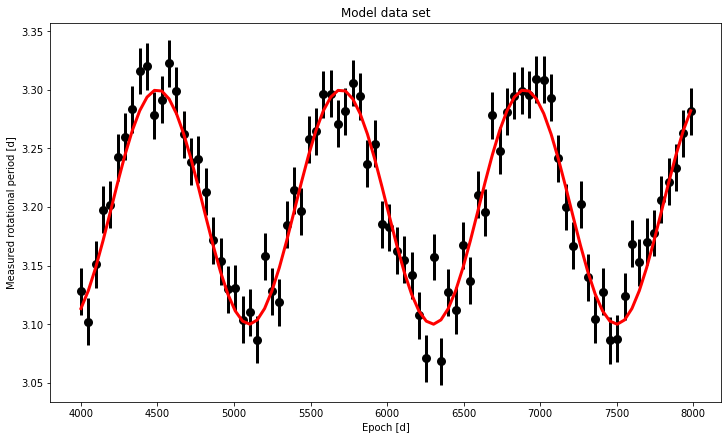

In [3]:
epoch = np.arange(4000,8000,48)


Pact_model = activity_model(epoch, period, t0, average_rotation_period, amp_rotation_period)


# make noisy data
noise = np.ones_like(Pact_model) * 0.02
Pact_noisy = Pact_model + np.random.normal(loc=0.0, scale=noise)


# plot it
fig1, f1a = plt.subplots(ncols=1,nrows=1, figsize=(10,6), constrained_layout=True)

f1a.errorbar(epoch,Pact_noisy,yerr=noise,fmt='o', color='black',ecolor='black',capsize=0 ,mew=3, elinewidth=3,ms=6)
f1a.plot(epoch,Pact_model,'r-',linewidth=3,zorder=10)

f1a.set_xlabel('Epoch [d]')
f1a.set_ylabel('Measured rotational period [d]')
f1a.set_title('Model data set')

## Initial fit to the data

To pick good starting parameters for our model we use LMFIT in Python. If you have already found good parameters, you can skip this bit. The output 'x' array contains the found solution.

In [4]:
# P, t0, mean, a
par =    [1200,         4200,       3.2,      0.1]
labels = ["$P_{act}$", "$t_0$", "$P_{mean}$", "$a$"]

## Defining our optimization function

Here `lnlike` calculates a single output number, which we are optmising. This is almost always the chi squared value, which should be a small number roughly equal to the number of input epochs, if allt he noise is gaussian and the model happens to be a good description of the data you have. (Usually the model is close, but not perfect - so don't worry if you get a big chi squared).

For technical reasons with emcee, it prefers to maximise a value instead of minimising, so that's why there's a minus sign in the returned chi squared.

In [5]:


def lnlike(theta, t, f, ferr):
    ''' theta holds the free parameters of the model, t,f, ferr are the noisy observed measurements'''
    P, t0, mean, a = theta

    # calculate the model with the values in theta, and the data in (t,f,ferr)
    model = activity_model(t, P, t0, mean, a)
    
    # calculate the chi squared for each epoch
    chi2 = np.power((f-model)/ferr,2.)
    
    # add up all the chi squareds, and the -0.5 is for emcee
    return -0.5*(np.sum(chi2))


# this nll function is for the minimise function, which wants a MINIMISE a value, not maximise it.
nll = lambda *args: -lnlike(*args)

### Run the minimiser

Here we put the function `nll` in, and the method for the optimiser, and then the arguments that we want to find the best values for. There's also a maximum number of times you iterate before you should give up (most optimisers may need several hundred iterations) and the precision (xtol) that you want.

The optimiser returns an object called `result` that contains lots of information about how well the optimiser did. The best fit values are in `result.x`

In [6]:


result = op.minimize(nll, par, method='nelder-mead', args=(epoch,Pact_noisy,noise),
                     options={'maxiter':10000,'xtol': 1e-8, 'disp': True})

print(result)

Optimization terminated successfully.
         Current function value: 43.389822
         Iterations: 153
         Function evaluations: 306
 final_simplex: (array([[1.19927426e+03, 4.19888415e+03, 3.20431081e+00, 9.94916808e-02],
       [1.19927426e+03, 4.19888415e+03, 3.20431081e+00, 9.94916808e-02],
       [1.19927426e+03, 4.19888415e+03, 3.20431081e+00, 9.94916808e-02],
       [1.19927426e+03, 4.19888415e+03, 3.20431081e+00, 9.94916808e-02],
       [1.19927426e+03, 4.19888415e+03, 3.20431081e+00, 9.94916808e-02]]), array([43.38982212, 43.38982212, 43.38982212, 43.38982212, 43.38982212]))
           fun: 43.38982211566766
       message: 'Optimization terminated successfully.'
          nfev: 306
           nit: 153
        status: 0
       success: True
             x: array([1.19927426e+03, 4.19888415e+03, 3.20431081e+00, 9.94916808e-02])


## emcee preparations

Okay, read the `emcee` document page to understand all the options. I'll skip this just to get to the intersting stuff.

https://emcee.readthedocs.io/en/stable/

Here we have `lnprior` and `lnprob` where you can program in sensible limits for your variables - if you want to make sure the optimiser doesn't wander off somewhere, you can put them here.

In [7]:
# prior - here we choose whether to restrict the fitting paramaters
def lnprior(theta):
    P, t0, mean, a = theta
    if 0 < P < 8000:
        return 0.0
    return -np.inf

In [8]:
def lnprob(theta, t, f, ferr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, t, f, ferr)

# Running emcee

Here we state that there are 4 free variables that we are putting into `emcee`, and the number of walkers that we start with. Each walker is one point in the n-dimensional space we are trying to minimise. All their positions are randomly scattered around the best guess starting point.

In [9]:
ndim, nwalkers = 4, 100
pos = [par + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

Now let's start them walking! These 100 walkers will wander semi-randomly around the n-space, and find the optimal solutions. Once there, they are 'shaken' around randomly (but not too strongly) so that their jittery walk explores the area around the minimum - this gives you the statistics and correlated errors for free! 

In [10]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(epoch,Pact_noisy,noise), threads=4)

In [11]:
pos, prob, state = sampler.run_mcmc(pos, 5000)

Now we can optionally shave the walker paths (called chains) to a file, in case the previous step took a long time.

In [12]:
# save the chains to file
np.savez_compressed('chains.npz', sampler.chain, sampler.lnprobability)

In [13]:
print(sampler.get_autocorr_time(c=1))
print(sampler.acceptance_fraction)

[36.52791042 36.61255032 35.95619803 36.54079036]
[0.6198 0.6022 0.6034 0.5938 0.597  0.5958 0.6018 0.5864 0.6012 0.5904
 0.597  0.5914 0.6002 0.5998 0.6062 0.5934 0.5982 0.5976 0.598  0.6008
 0.6006 0.5734 0.5924 0.5914 0.6028 0.5888 0.6088 0.6042 0.5964 0.6002
 0.6002 0.6044 0.5906 0.5952 0.594  0.6008 0.5844 0.5966 0.6086 0.5952
 0.5994 0.6026 0.5954 0.5816 0.5928 0.5948 0.6052 0.6026 0.6032 0.5922
 0.572  0.5868 0.6002 0.5818 0.5968 0.595  0.6078 0.5844 0.5902 0.5938
 0.5834 0.592  0.599  0.5832 0.5876 0.6022 0.5912 0.6044 0.5984 0.579
 0.5922 0.602  0.5922 0.5932 0.5896 0.5882 0.5954 0.5884 0.591  0.6008
 0.5872 0.584  0.5848 0.595  0.5974 0.5808 0.5934 0.5914 0.6    0.5828
 0.5826 0.6    0.586  0.598  0.601  0.5954 0.5848 0.5896 0.5862 0.5954]


Now we can look at how the 100 walkers did. The step number is on the x-axis, and what you want ideally is that the 100 walkers have fuzzed out into the minimisation bowl, and have settled down into wandering around. IN our case, this is after about 150 steps, so what we usually do is remove the first 300 or 400 steps and keepf the rest of the steps because the walkers have settled down into equilibrium.

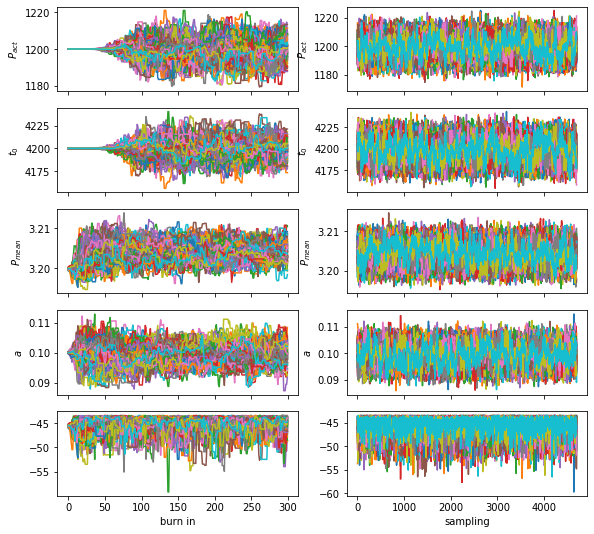

In [14]:
# see what the chains look like, skip a burn in period if desired
burn = 300
fig,ax = plt.subplots(ndim+1,2,figsize=(9.5,9),sharex='col',sharey=False)

for j in range(nwalkers):
    ax[-1,0].plot(sampler.lnprobability[j,:burn])
    for i in range(ndim):
        ax[i,0].plot(sampler.chain[j,:burn,i])
        ax[i,0].set_ylabel(labels[i])

for j in range(nwalkers):
    ax[-1,1].plot(sampler.lnprobability[j,burn:])
    for i in range(ndim):
        ax[i,1].plot(sampler.chain[j,burn:,i])
        ax[i,1].set_ylabel(labels[i])

ax[-1,0].set_xlabel('burn in')
ax[-1,1].set_xlabel('sampling')
fig.savefig('chains.pdf')

## seeing the results
Here we draw the triangle diagram, removing the first 300 steps of the walkers. Here we see that the distributions for each variable look nicely gaussian, and we see that there is a strong correlation between t_0 and P_act, which we would expect. Everything else is uncorrelated.

In [15]:
# samples for deriving fitted parameters an uncertainties

print(sampler.chain.shape)
samples = sampler.chain[:, burn:, :].reshape((-1, ndim))
print(samples.shape)

(100, 5000, 4)
(470000, 4)


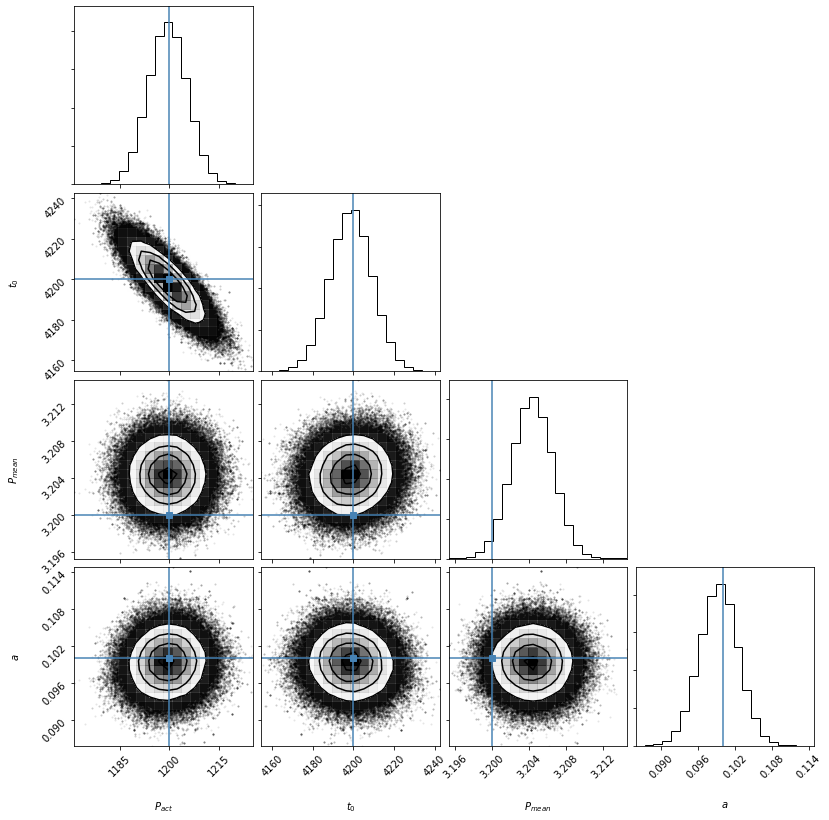

In [16]:
fig, ax = plt.subplots(ndim,ndim, figsize=(12,12))

fig = corner.corner(samples, labels=labels, show_titles=False, fig=fig, truths=[period, t0, average_rotation_period, amp_rotation_period])
fig.savefig("triangle-raw.pdf")

We can also look at what 100 of the walkers samples look like in our data:

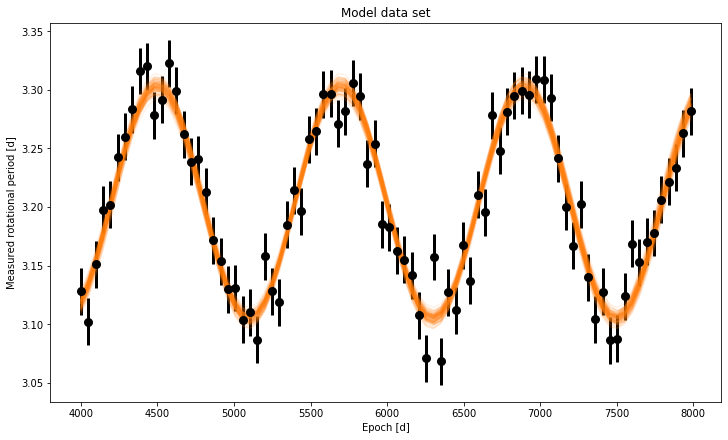

In [17]:
inds = np.random.randint(len(samples), size=100)


fig1, f1a = plt.subplots(ncols=1,nrows=1, figsize=(10,6), constrained_layout=True)


# make noisy data
f1a.errorbar(epoch,Pact_noisy,yerr=noise,fmt='o', color='black',ecolor='black',capsize=0 ,mew=3, elinewidth=3,ms=6)
##f1a.plot(epoch,Pact_model,'r-',linewidth=3,zorder=10)

f1a.set_xlabel('Epoch [d]')
f1a.set_ylabel('Measured rotational period [d]')
f1a.set_title('Model data set')
for ind in inds:
    onesample = samples[ind]
    P, t0, mean, a = onesample

    # calculate the model with the values in theta, and the data in (t,f,ferr)
    onemodel = activity_model(epoch, P, t0, mean, a)    
    plt.plot(epoch, onemodel, "C1", alpha=0.1)

In [21]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.1f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>